Second try for Logistic Regression model

- Replace NaN with median instead of 0
- Include text columns with One-Hot encoding

In [1]:
# Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load the data
df = pd.read_csv("dataset_samuel.csv")
display(df.head())

,Gene1,Gene2,gene,family_size,duplicate,Classification1,PPI_Interactant_G1,PPI_Interactant_G2,PPI_Intersection,PPI_Union,...,coverage_TE_G1,density_TE_G1,nb_TE_G1,coverage_TE_G2,density_TE_G2,nb_TE_G2,TE_environment_G1,TE_environment_G2,TE_environment_pair,TE_environment_class
0,AT1G01010,AT4G01520,AT4G01520,4.0,True,NaN,0.0,13.0,0.0,13.0,...,0.000000,0.000000,0.0,16.789722,0.532387,3.0,TE-poor,TE-free,TE-free_TE-poor,half
1,AT1G01010,AT4G01540,NaN,NaN,True,NaN,2.0,13.0,0.0,15.0,...,0.000000,0.000000,0.0,1.522118,0.161005,1.0,TE-free,TE-free,TE-free_TE-free,free
2,AT1G01010,AT4G01550,AT4G01550,4.0,True,NaN,8.0,13.0,0.0,21.0,...,0.000000,0.000000,0.0,1.465649,0.154943,1.0,TE-free,TE-free,TE-free_TE-free,free
3,AT1G01020,AT4G01510,NaN,NaN,True,NaN,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,1.695218,0.181521,1.0,TE-free,TE-free,TE-free_TE-free,free
4,AT1G01030,AT2G46870,AT2G46870,4.0,True,1.0,6.0,4.0,1.0,9.0,...,1.318826,0.167056,1.0,5.777292,0.193424,1.0,TE-free,TE-free,TE-free_TE-free,free


# Data preprocessing

In [2]:
# Filtering
df_model = df[ (df['duplicate'] == True) & (df['Classification1'].notna()) ].copy()

# Features selection 

# Numerical features here I removed the individual PPI
features_num = [
    'family_size', 
    'PPI_Intersection', 'Pfam_G1',
    'Ks', 'Ka', 'Ka_Ks', 
    'coverage_TE_G1', 'coverage_TE_G2'
]

# Categorical features
features_cat = [
    'TE_environment_pair',  # Ex: "poor_free"
    'TE_environment_class'  # Ex: "half", "free"
]

In [3]:
# NaN values handling
# For numerical fetaures the median is used
for col in features_num:
    mediane = df_model[col].median()
    df_model[col] = df_model[col].fillna(mediane)

# For categorical features, we can fill NaN with a new category "Unknown"
for col in features_cat:
    df_model[col] = df_model[col].fillna("Unknown")

# One-hot encoding for categorical features
X_cat_encoded = pd.get_dummies(df_model[features_cat], drop_first=True)

# Assemble the final feature set
X_num = df_model[features_num]
X_final = pd.concat([X_num, X_cat_encoded], axis=1)

y = df_model['Classification1']

print(f"Number of features after encoding: {X_final.shape[1]}")


Number of features after encoding: 15


# Split and Scaling

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training

In [5]:
# With regularization to avoid overfitting
model = LogisticRegression(max_iter=2000, class_weight='balanced', C=1, random_state=42)
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


# Results and Interpretation

Accuracy : 74.02%

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.65      0.79      0.71        52
         1.0       0.83      0.71      0.76        75

    accuracy                           0.74       127
   macro avg       0.74      0.75      0.74       127
weighted avg       0.76      0.74      0.74       127



C:\Users\erine\AppData\Local\Temp\ipykernel_20616\1070250623.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=coeffs, palette='vlag')


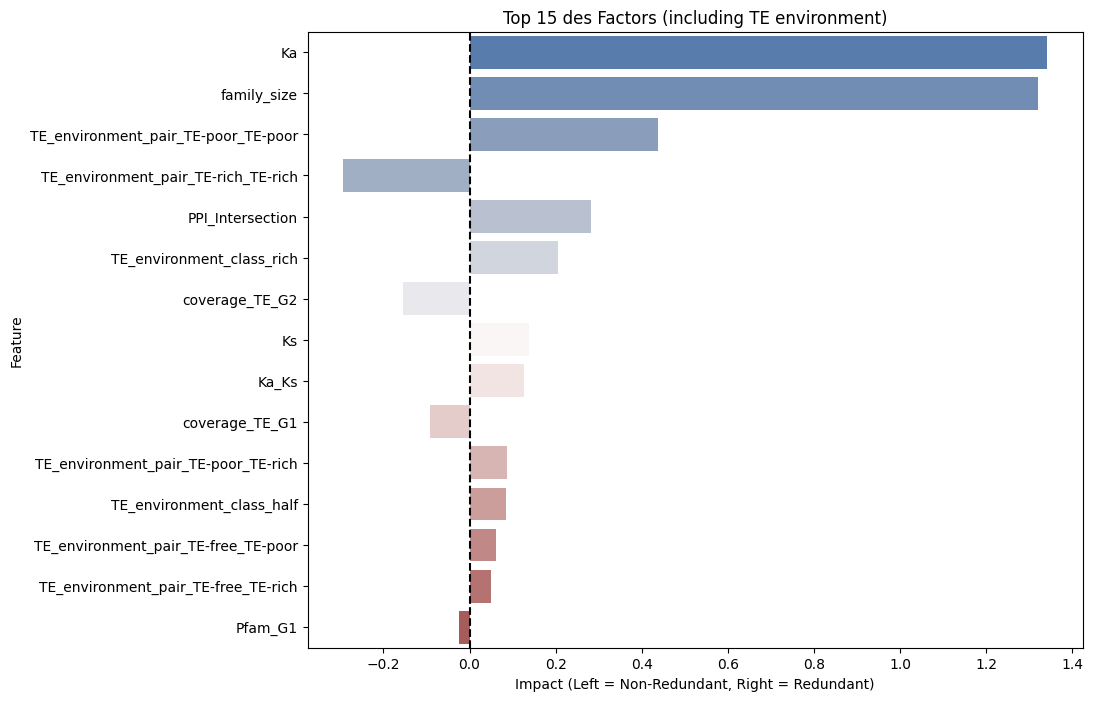

In [6]:
y_pred = model.predict(X_test_scaled)

print(f"Accuracy : {accuracy_score(y_test, y_pred):.2%}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Visualisation des NOUVEAUX coefficients
coeffs = pd.DataFrame({
    'Feature': X_final.columns, 
    'Weight': model.coef_[0],
    'Abs_Weight': abs(model.coef_[0])
})
coeffs = coeffs.sort_values(by='Abs_Weight', ascending=False).head(15) # Top 15

plt.figure(figsize=(10, 8))
sns.barplot(x='Weight', y='Feature', data=coeffs, palette='vlag')
plt.axvline(0, color='black', linestyle='--')
plt.title("Top 15 des Factors (including TE environment)")
plt.xlabel("Impact (Left = Non-Redundant, Right = Redundant)")
plt.show()

# Cross validation

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression(max_iter=2000, class_weight='balanced', C=1.0, random_state=42)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X_final, y, cv=cv, scoring='accuracy')

print(f"Scores of the 5 tries : {scores}")
print(f"\n--- FINAL RESULT ---")
print(f"Average Accuracy : {scores.mean():.2%} (+/- {scores.std():.2%})")

Scores of the 5 tries : [0.75294118 0.68235294 0.69047619 0.71428571 0.73809524]

--- FINAL RESULT ---
Average Accuracy : 71.56% (+/- 2.70%)
